In [20]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys  
sys.path.append("../l2hmc")
sys.path.append("../l2hmc/utils")
from __future__ import division

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.distributions import random_tilted_gaussian, Gaussian, GMM, RoughWell

import seaborn as sns
sns.set_palette("muted")

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples, plot_gaussian_contours

Instructions for updating:
Use the retry module or similar alternatives.


In [125]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [4]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net


---
# Rough Well (RW)

## Defining the distribution

In [5]:
x_dim = 2
eta = 1e-2
mu, cov = np.array([[0, 0]]), np.array([np.eye(2)])
Ω = RoughWell(x_dim, eta, easy=True)

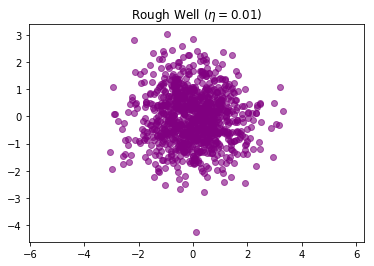

In [71]:
S = Ω.get_samples(1000)
plt.title('Rough Well ($\eta = 0.01$)')
# plot_gaussian_contours(mu, cov, colors=[c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
plt.axis('equal')
plt.show()

---
## Training

In [7]:
# Leap frog integrator for Hamiltonian dynamics
dynamics = Dynamics(x_dim, Ω.get_energy_function(), T=10, eps=0.1, net_factory=network)

# Losses on p(xi) and q(xi), respectively
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))
Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

# Squared jumped distance
v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

# Update loss
loss = 0.
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [8]:
# Training parameters
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

In [9]:
n_steps = 1000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))

Step: 0 / 1000, Loss: -3.22e+01, Acceptance sample: 0.87, LR: 0.00100
Step: 100 / 1000, Loss: -3.17e+01, Acceptance sample: 0.89, LR: 0.00100
Step: 200 / 1000, Loss: -3.09e+01, Acceptance sample: 0.83, LR: 0.00100
Step: 300 / 1000, Loss: -3.07e+01, Acceptance sample: 0.89, LR: 0.00100
Step: 400 / 1000, Loss: -3.65e+01, Acceptance sample: 0.85, LR: 0.00100
Step: 500 / 1000, Loss: -3.30e+01, Acceptance sample: 0.84, LR: 0.00100
Step: 600 / 1000, Loss: -3.36e+01, Acceptance sample: 0.87, LR: 0.00100
Step: 700 / 1000, Loss: -3.34e+01, Acceptance sample: 0.88, LR: 0.00100
Step: 800 / 1000, Loss: -3.82e+01, Acceptance sample: 0.84, LR: 0.00100
Step: 900 / 1000, Loss: -3.91e+01, Acceptance sample: 0.84, LR: 0.00100


---
## Evaluating

In [19]:
samples = Ω.get_samples(n=n_samples)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [11]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.6, Ω.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.8, Ω.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 1.0, Ω.get_energy_function(), sess, steps=2000, samples=samples)

In [12]:
#scale = np.sqrt(np.trace(cov))
scale = 1.
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

---
## Auto-correlation plot

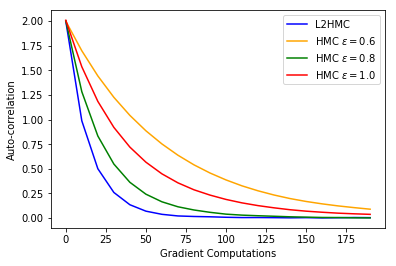

In [72]:
xaxis = 10 * np.arange(20)
plt.plot(xaxis, L2HMC[:20], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:20], label='HMC $\epsilon=0.6$', color=c_hmc1)
plt.plot(xaxis, HMC2[:20], label='HMC $\epsilon=0.8$', color=c_hmc2)
plt.plot(xaxis, HMC3[:20], label='HMC $\epsilon=1.0$', color=c_hmc3)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [26]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %.3f' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 2.04e-01 -- ESS HMC: 1.08e-01 -- Ratio: 1.892


Finally, we visualize a single chain of L2HMC for 50 time steps to assess exploration.

### L2HMC samples overlayed on ground truth samples

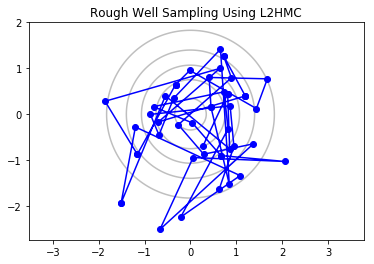

In [120]:
plot_gaussian_contours(mu, cov, colors=[c_contour], x_lims=[-2,2], y_lims=[-2,2])
plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color=c_l2hmc, marker='o')
plt.title('Rough Well Sampling Using L2HMC')
plt.axis('equal')
plt.show()

### HMC samples (Leapfrog step: ε = 0.6)

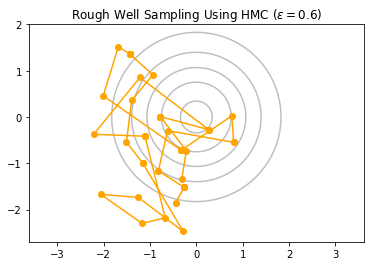

In [121]:
plot_gaussian_contours(mu, cov, colors=[c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(HMC_samples_1[:50, 1, 0], HMC_samples_1[:50, 1, 1], color=c_hmc1, marker='o')
plt.title('Rough Well Sampling Using HMC ($\epsilon = 0.6$)')
plt.axis('equal')
plt.show()

### HMC samples (Leapfrog step: ε = 0.8)

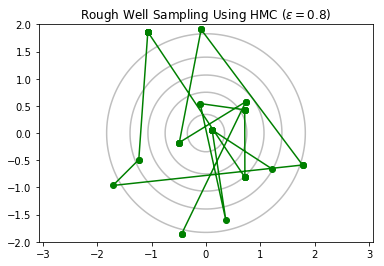

In [123]:
plot_gaussian_contours(mu, cov, colors=[c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(HMC_samples_2[:50, 1, 0], HMC_samples_2[:50, 1, 1], color=c_hmc2, marker='o')
plt.title('Rough Well Sampling Using HMC ($\epsilon = 0.8$)')
plt.axis('equal')
plt.show()

### HMC samples (Leapfrog step: ε = 1.0)

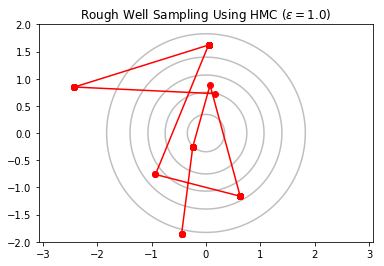

In [124]:
plot_gaussian_contours(mu, cov, colors=[c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(HMC_samples_3[:50, 1, 0], HMC_samples_3[:50, 1, 1], color=c_hmc3, marker='o')
plt.title('Rough Well Sampling Using HMC ($\epsilon = 1.0$)')
plt.axis('equal')
plt.show()